# For processing UV-Vis spectroelectrochemistry data
### Rajiv Giridharagopal, rgiri@uw.edu

Last updated 12/16/2019

You can run this notebook by hitting **shift-click** on each cell (including this one!)

In [2]:
import os
os.chdir(r'C:\Users\raj\Documents\Coding\OECT_processing')

import uvvis
import cv
from matplotlib import pyplot as plt
import numpy as np
import scipy as sps
import pickle
import pandas as pd
from pathlib import Path

plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (16, 8)

### Set up Data paths and global processing variables

In [121]:
# 1) Set up the data path

# edit this line is you want to hard-code a path, otherwise this lets you choose a folder
# Otherwise leave it as COPY_PATH_TO_FOLDER_HERE and it will ask you to find a folder

data_path = r'COPY_PATH_TO_FOLDER_HERE'

In [122]:
# Windows example: r'C:\Users\Raj\OneDrive\Documents\Word\uvvis'
# Linux example: '/home/name/path/to/dataset/20191206'
# MacOS example: '/Users/name/path/to/dataset/20191206'
# 'r' is for raw treatment of the string so '\' is not interpreted as a control character

#data_path = r'/Users/waldow/Downloads/20191206/R4'

# don't edit this
if data_path == 'COPY_PATH_TO_FOLDER_HERE':
    from oect_load import file_open
    data_path = file_open(caption='Select folder to load from')
    print('Loading from', data_path)

# 2) Select the wavelength for extracting kinetics, and the potential for plotting time-dependent spectra
wavelength = 500
potential = 0.7

# 3) Any potential time segments to ignore (e.g. droptimes = [0.0, 0.1])
droptimes = [] 

# 4) For saving the figures, add a small string to the filename. e.g. "20190825". By default it's blank
filenamestring = ''

# 5) Save path. By default this will just be in the data path
path = data_path
data_folder = Path(data_path)

In [123]:
# This block reads all the text files and saves them as a list of file paths for Python to read
#   Steps = the voltage steps. Not actually needed but it contains the current
#   Specs = spectra
#   Volts = potentials extracted from the steps files

steps, specs, volts, dedopesteps, dedopespecs = uvvis.read_files(data_folder)

## 1. Process Data!

#### Here's what this block does:

First, we load the data as a uvvis object
> data = uvvis.uvvis(steps, specs, volts)

1) Now, we process the data by reading in all the spectra at each voltage.  
This step takes all the spectra and saves the time=0 s (initial) spectra at each voltage as a big matrix
It then extracts absorbance vs voltage at a specific wavelength. The command below is at 500 nm
> data.spec_echem_voltage(wavelength=500)

2) Then, we create a giant dictionary that contains a huge matrix of each time-dependent spectra  
> data.time_dep_spectra()

To access the 0.7 V, for example, you'd run this then type 
> data.spectra_vs_time[0.7]

3) Finally, we extract a single time-dependent kinetics trace. Edit the potential and wavelength (wl) based on your data. The command below plots the kinetics for the 0.7 V case and wavelength=500 nm:
> data.single_wl_time(wavelength = 500, potential = 0.7)

4) As an option, we can extract the current from the 'steps' files. This is not that critical
> data.current_vs_time()

Lastly, this saves the data as 2 ".PKL" (pickle) files, dopingdata.pkl and dedopingdata.pkl. It's ~120 MB as opposed to 2 GB, and contains all the data!

In [124]:
# Load Data

# Did you already load any data? If so, this avoids reprocessing. You can manually override this by changing to True
overwrite = True

if not overwrite:
    try:

        working_path = data_folder / "dopingdata.pkl"
        with open(working_path, 'rb') as input:

            data = pickle.load(input)
        print('Loaded existing doping data')

        working_path = data_folder / "dedopingdata.pkl"

        with open(working_path, 'rb') as input:
            dedata = pickle.load(input)
            
        print('Loaded existing dedoping data')
        print('If you REALLY want to re-process all the data, change overwrite to True. You should not need to do this.')
        
    except:
        overwrite = True

if overwrite:
    ####### LOAD DATA ######
    data = uvvis.uv_vis(steps, specs, volts)

    # Actual processing of data. This takes a long time!!
    print('Processing data...hold on!')
    
    # Time-dependent spectra
    print('Generating spectra vs time')
    try:
        data.time_dep_spectra(specfiles=specs, droptimes=droptimes) 
    except:
        print('time-dependent spectra failed')
    
    # Single wavelength kinetics
    print('Extracting single wavelength kinetics')
    try:
        data.single_wl_time(wavelength=wavelength, potential=potential)
    except:
        print('single wavelength spectra failed')
        
    # Integrated current
    print('Current extraction')
    try:
        data.current_vs_time(stepfiles=steps)
        print('Total integrated charge at each voltage')
        print(data.charge)
    except:
        data.charge=[0]
        print('current extraction failed')
        
    # Time slice spectra
    print('Single DataFrame of time slice t=0')
    try:
        data.spec_echem_voltage(time=0)
    except:
        print('time-slice spectra failed')
    
    working_path = data_folder / "dopingdata.pkl"
    with open(working_path, 'wb') as output:

        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

    #### DEDOPING DATA ######
        
    if any(dedopespecs):
        dedata = uvvis.uv_vis(dedopesteps, dedopespecs, volts)
        print('### Dedoping Data ###' )
        
        print('Processing data...hold on!')
        # Time-dependent spectra
        print('Generating spectra vs time')
        try:
            dedata.time_dep_spectra(specfiles=dedopespecs, droptimes=droptimes) 
        except:
            print('time-dependent spectra failed')

        # Single wavelength kinetics
        print('Extracting single wavelength kinetics')
        try:
            dedata.single_wl_time(wavelength=wavelength, potential=potential)
        except:
            print('single wavelength spectra failed')
        # Integrated current
        print('Current extraction')
        try:
            dedata.current_vs_time(stepfiles=dedopesteps)
            print('Total integrated charge at each voltage')
            print(dedata.charge)
        except:
            dedata.charge=[0]
            print('current extraction failed')
        
        # Time slice spectra
        print('Single DataFrame of time slice t=0')
        try:
            dedata.spec_echem_voltage(time=0)
        except:
            print('time-slice spectra failed')
    
        working_path = data_folder / "dedopingdata.pkl"
        with open(working_path, 'wb') as output:

    
            pickle.dump(dedata, output, pickle.HIGHEST_PROTOCOL)
    else:
        dedata = [] # flag for later
print('This section is done!')

# Saves as an HDF5, more flexible than a Pickle
import h5py

working_path = data_folder / 'dopingdata.h5'

uvvis.save_h5(data, working_path)

if any([dedata]):
    working_path = data_folder / 'dedopingdata.h5'
    uvvis.save_h5(dedata, working_path)

Processing data...hold on!
Generating spectra vs time
Extracting single wavelength kinetics
Current extraction
Total integrated charge at each voltage
Potential (V)     -0.3       0.0       0.2       0.4       0.5       0.6  \
0              0.00268 -0.000853 -0.003627 -0.008935 -0.014531 -0.036652   

Potential (V)       0.7       0.8      0.9       1.0  
0             -0.101677 -0.202548 -0.35815 -0.537195  
Single DataFrame of time slice t=0
This section is done!


C:\Users\raj\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-0.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\raj\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\raj\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [125]:
# Visualize the tree

try:
    import pyUSID as usid
    h5_file = h5py.File(working_path)
    usid.hdf_utils.print_tree(h5_file, rel_paths=True)
    h5_file.close()
except:
    print('error in printing tree')

/
-0.3
-0.3/axis0
-0.3/axis1
-0.3/block0_items
-0.3/block0_values
0.0
0.0/axis0
0.0/axis1
0.0/block0_items
0.0/block0_values
0.2
0.2/axis0
0.2/axis1
0.2/block0_items
0.2/block0_values
0.4
0.4/axis0
0.4/axis1
0.4/block0_items
0.4/block0_values
0.5
0.5/axis0
0.5/axis1
0.5/block0_items
0.5/block0_values
0.6
0.6/axis0
0.6/axis1
0.6/block0_items
0.6/block0_values
0.7
0.7/axis0
0.7/axis1
0.7/block0_items
0.7/block0_values
0.8
0.8/axis0
0.8/axis1
0.8/block0_items
0.8/block0_values
0.9
0.9/axis0
0.9/axis1
0.9/block0_items
0.9/block0_values
1.0
1.0/axis0
1.0/axis1
1.0/block0_items
1.0/block0_values
charge
current
current/axis0
current/axis1
current/block0_items
current/block0_values
potentials


C:\Users\raj\anaconda3\lib\site-packages\ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """


## 2. Cool Plots!

### First, simple spectra vs voltage

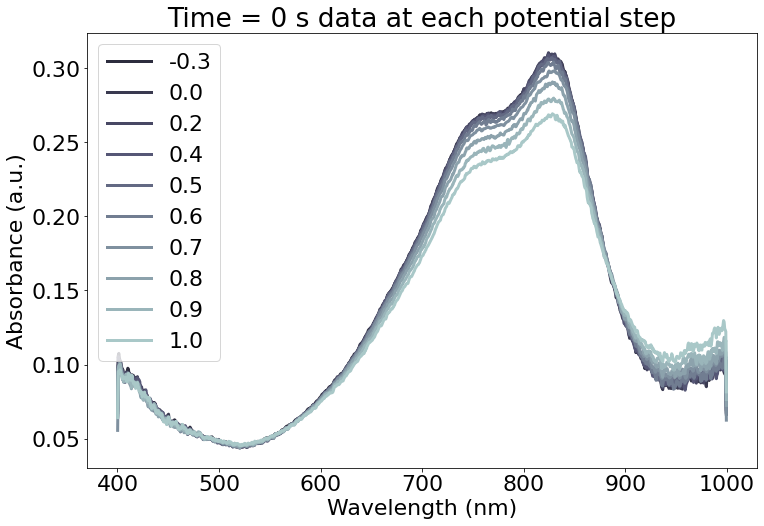

In [126]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8), facecolor='white')
plt.rcParams.update({'font.size': 22})

# This block just generates a cool colormap
# In the last line, you can replace "bone" with any colormap name from here: 
#     https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
cm = np.linspace(0.2,0.75,len(data.spectra_sm.columns))
for i,cl in zip(data.spectra_sm, cm):
    ax.plot(data.spectra_sm[i], linewidth=3,
           color=plt.cm.bone(cl))  

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (a.u.)')
ax.legend(labels = data.potentials)
ax.set_title('Time = 0 s data at each potential step')

plot_name =  'Doping Spectra, t=0 s'+filenamestring+'.png'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Doping Spectra, t=0 s'+filenamestring+'.jpg')
plt.savefig(working_path)

if dedata:
    fig, ax = plt.subplots(nrows=1, figsize=(12,8), facecolor='white')
    plt.rcParams.update({'font.size': 22})

    # This block just generates a cool colormap
    # In the last line, you can replace "bone" with any colormap name from here: 
    #     https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    cm = np.linspace(0.2,0.75,len(data.spectra_sm.columns))
    for i,cl in zip(dedata.spectra_sm, cm):
        ax.plot(dedata.spectra_sm[i], linewidth=3,
               color=plt.cm.bone(cl))  

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance (a.u.)')
    ax.legend(labels = dedata.potentials)
    ax.set_title('Time = 0 s data at each dedoping potential step')

    plot_name = 'Dedoping Spectra, t=0 s'+filenamestring+'.png'
    working_path = data_folder / plot_name
#    plt.savefig(path + r'//' + 'Dedoping Spectra, t=0 s'+filenamestring+'.jpg')
    plt.savefig(working_path)



### Now, let's plot spectra vs time for a particular voltage.
##### Change this line
> potential = 0.7 
##### to whatever voltage you want to plot the kinetics of

"\n\ncm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))\nfor i,cl in zip(data.spectra_vs_time[potential], cm):\n    ax.plot(data.spectra_vs_time[potential][i], color=plt.cm.bone(cl*1))\n    \nax.set_xlabel('Wavelength (nm)')\nax.set_ylabel('Absorbance (a.u.)')\nax.set_title(str(potential) +' V doping kinetics over ' + str(endtime) + ' s')\n\nplot_name = 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg'\nworking_path = data_folder / plot_name\n#plt.savefig(path + r'//' + 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg')\nplt.savefig(working_path)\n\n\nif dedata:\n    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')\n\n    #potential = 0.7 # Change this to whatever voltage you want to plot\n\n    endtime = dedata.spectra_vs_time[potential].columns[-1]\n    cm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))\n    for i,cl in zip(dedata.spectra_vs

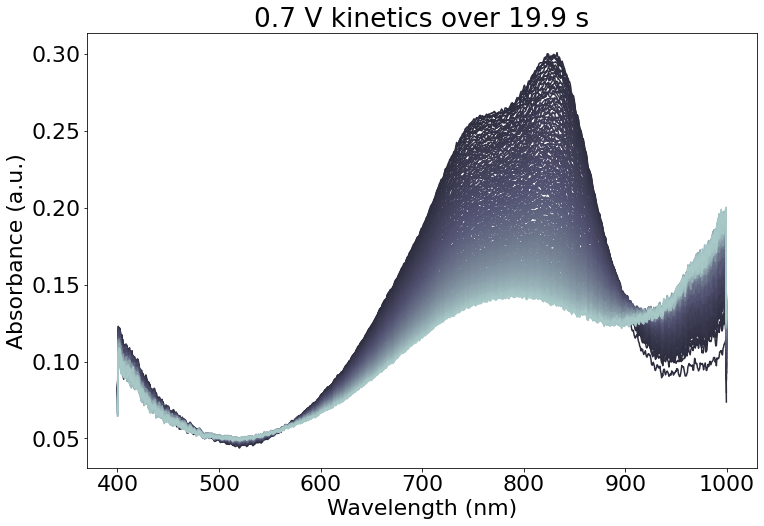

In [127]:
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')

potential = 0.7 # Change this to whatever voltage you want to plot

endtime = data.spectra_vs_time[potential].columns[-1]

ax = uvvis.plot_spectra_vs_time(data, ax=ax, potential=potential, crange=[0.2, 0.75])
plot_name = 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.png'
working_path = data_folder / plot_name
plt.savefig(working_path)

if dedata:
    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
    ax = uvvis.plot_spectra_vs_time(dedata, ax=ax, potential=potential, crange=[0.2, 0.75])

    plot_name = 'Dedoping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.png'
    working_path = data_folder / plot_name
    plt.savefig(working_path)

    
# If you'd like more control, here's the code behind the plot_spectra_vs_time function
'''

cm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))
for i,cl in zip(data.spectra_vs_time[potential], cm):
    ax.plot(data.spectra_vs_time[potential][i], color=plt.cm.bone(cl*1))
    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (a.u.)')
ax.set_title(str(potential) +' V doping kinetics over ' + str(endtime) + ' s')

plot_name = 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Doping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg')
plt.savefig(working_path)


if dedata:
    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')

    #potential = 0.7 # Change this to whatever voltage you want to plot

    endtime = dedata.spectra_vs_time[potential].columns[-1]
    cm = np.linspace(0.2,0.75,len(data.spectra_vs_time[potential].columns))
    for i,cl in zip(dedata.spectra_vs_time[potential], cm):
        ax.plot(dedata.spectra_vs_time[potential][i], color=plt.cm.bone(cl*1))

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance (a.u.)')
    ax.set_title(str(potential) +' V dedoping kinetics over ' + str(endtime) + ' s')

    plot_name = 'Dedoping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg'
    working_path = data_folder / plot_name
#    plt.savefig(path + r'//' + 'Dedoping Spectra at '+str(potential) +' V over ' + str(endtime) + ' s'+filenamestring+'.jpg')
    plt.savefig(working_path)

'''



### Plot the kinetics at a particular wavelength and voltage

##### Change these lines
> potential = 0.7  
> wavelength = 800  
##### to whatever voltage and wavelength you want

In [128]:
def exp_fit(t, y, A, tau):
    return y + A * np.exp(-t / tau)

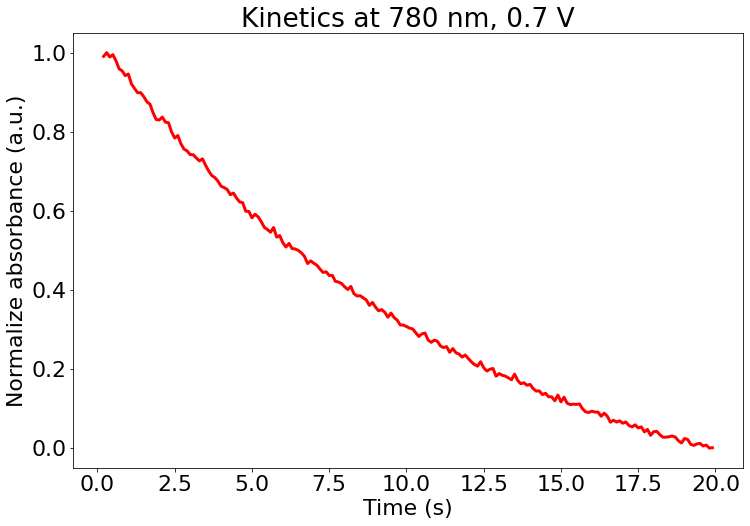

In [129]:
# Changes these two lines to whatever potential and wavelength you want
potential = 0.7
wavelength = 780

data.single_wl_time(potential=potential, wavelength = wavelength)
data_name = 'doping abs vs time, '+str(potential)+ ' at '+str(wavelength) + ' nm'+'.csv'
working_path = data_folder / data_name
data.time_spectra_sm.T.to_csv(working_path)

fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
uvvis.plot_time(data, ax=ax, **{'color':'r', 'linewidth': 3})
ax.set_title('Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V')

plot_name = 'Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V' +filenamestring+'.png'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V'
#            +filenamestring+'.jpg')
plt.savefig(working_path)


if dedata:
    dedata.single_wl_time(potential=potential, wavelength = wavelength)
    
    data_name = 'dedoping abs vs time, '+str(potential)+ ' at '+str(wavelength) + ' nm'+'.csv'
    working_path = data_folder / data_name
    dedata.time_spectra_sm.T.to_csv(working_path)
    
    fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
    uvvis.plot_time(dedata, ax=ax, **{'color':'r', 'linewidth': 3})
    ax.set_title('Dedoping Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V')

    plot_name = 'Dedope Kinetics at ' + str(wavelength) + ' nm, ' + str(potential) + ' V'+filenamestring+'.png'
    working_path = data_folder / plot_name    
    plt.savefig(working_path)

### Plot the kinetics over a band of wavelengths at a given voltage and/or charge integrated

C:\Users\raj\Documents\Coding\OECT_processing\uvvis.py:467: RuntimeWarning: overflow encountered in exp
  return y0 + A * np.exp(-t / tau)
C:\Users\raj\anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\raj\Documents\Coding\OECT_processing\uvvis.py:467: RuntimeWarning: overflow encountered in exp
  return y0 + A * np.exp(-t / tau)
C:\Users\raj\anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\raj\anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\raj\Documents\Coding\OECT_processing\uvvis.py:467: RuntimeWarning: overflow encountered in exp
  return y0 + A * np.exp(-t / tau)
C:\Users\raj\Documents\Coding\OECT_processing\uvvis.py:467: RuntimeWarning: 

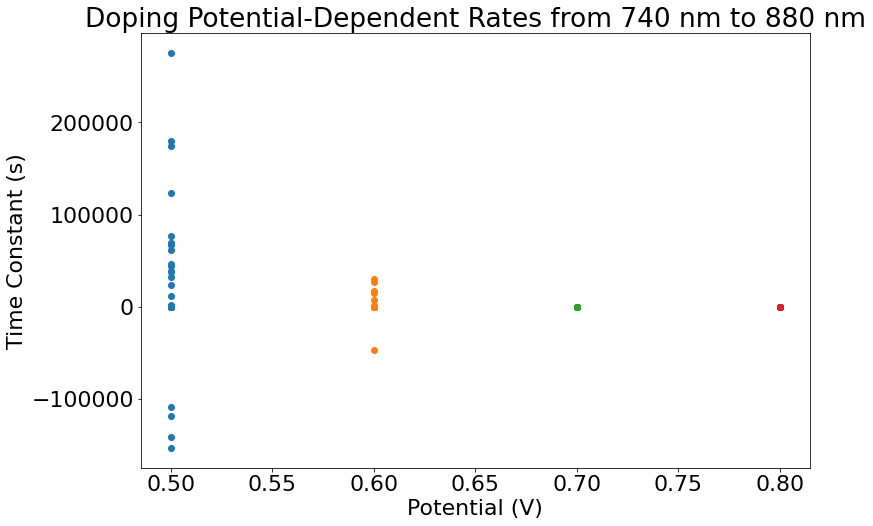

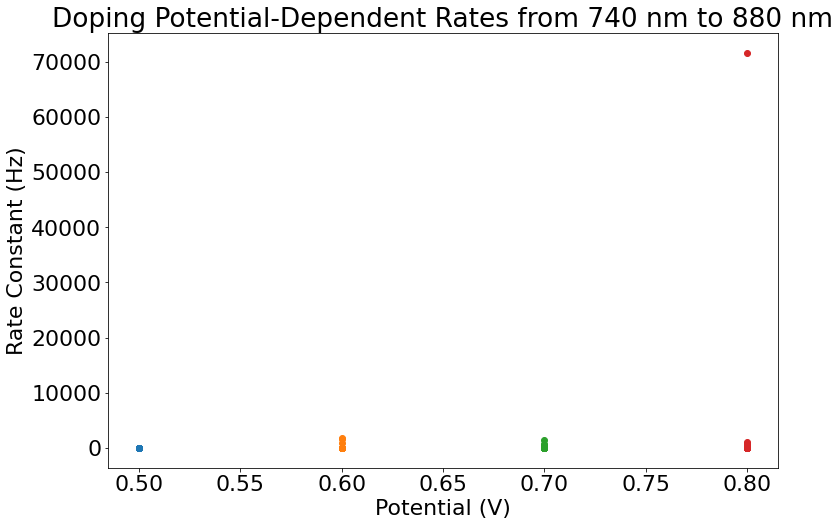

In [30]:
#Choose wavelengths to plot about
wl_start = 740
wl_stop = 880
potentials = [0.5, 0.6, 0.7, 0.8]
times = {}

# Setup variables for saving data as CSV - DW
potential_volt = []
time_constant_ave = []
std_tc = []
tc_array = []

fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(p * np.ones(len(data.fits)), times[p], 'o')

    filename_var = "all_tcs_"+str(p)+".csv"
    save_name_path =  data_folder  / filename_var
    np.savetxt(save_name_path, times[p], delimiter=",")
    
    potential_volt.append(p)
    time_constant_ave.append(np.mean(times[p]))
    std_tc.append(np.std(times[p]))    

# Saves time constant as CSV containing potential, time constant, standard deviation
filename_var = "tc_mean_range.csv"
save_name_path =  data_folder  / filename_var
tc_array = np.vstack((potential_volt, time_constant_ave, std_tc)).T
np.savetxt(save_name_path, tc_array, delimiter=",")    
    
ax.set_ylabel('Time Constant (s)')
ax.set_xlabel('Potential (V)')
ax.set_title('Doping Potential-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')

plot_name = 'Doping Potential-Dependent Kinetics from '+str(wl_start)+' nm to '+str(wl_stop )+' nm'+filenamestring+'.png'
working_path = data_folder / plot_name
plt.savefig(working_path)

fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(p * np.ones(len(data.fits)), np.array(data.fits)**-1, 'o')
    
ax.set_ylabel('Rate Constant (Hz)')
ax.set_xlabel('Potential (V)')
ax.set_title('Doping Potential-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')

plot_name = 'Doping Potential-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'+filenamestring+'.png'
working_path = data_folder / plot_name
plt.savefig(working_path)

C:\Users\raj\Documents\Coding\OECT_processing\uvvis.py:467: RuntimeWarning: overflow encountered in exp
  return y0 + A * np.exp(-t / tau)
C:\Users\raj\anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\raj\Documents\Coding\OECT_processing\uvvis.py:467: RuntimeWarning: overflow encountered in exp
  return y0 + A * np.exp(-t / tau)
C:\Users\raj\anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


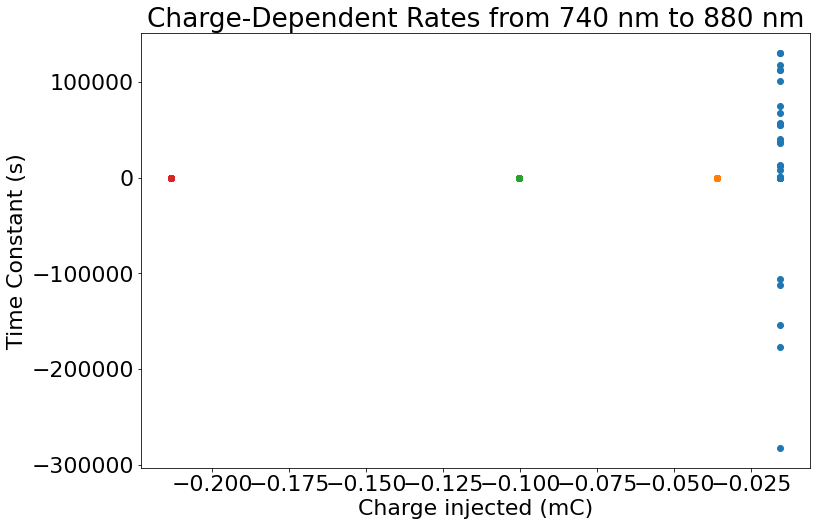

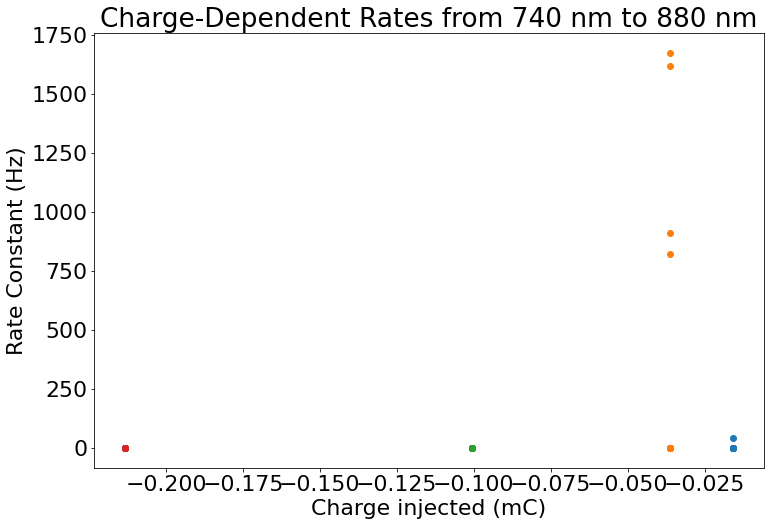

In [19]:
#Choose wavelengths to plot about
wl_start = 740
wl_stop = 880
potentials = [0.5, 0.6, 0.7, 0.8]
times = {}

fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(data.charge[p].values * np.ones(len(data.fits)), data.fits, 'o')
    
ax.set_ylabel('Time Constant (s)')
ax.set_xlabel('Charge injected (mC)')
ax.set_title('Charge-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')

plot_name = 'Doping Charge-Dependent Kinetics from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'+filenamestring+'.png'
working_path = data_folder / plot_name
#plt.savefig(path + r'/' + 'Doping Charge-Dependent Kinetics from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'
#            +filenamestring+'.jpg')
plt.savefig(working_path)

            
fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
for p in potentials:
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p)
    times[p] = data.fits
    ax.plot(data.charge[p].values * np.ones(len(data.fits)), np.array(data.fits)**-1, 'o')

    
ax.set_ylabel('Rate Constant (Hz)')
ax.set_xlabel('Charge injected (mC)')
ax.set_title('Charge-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')

plot_name =  'Doping Charge-Dependent Rates from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'+filenamestring+'.png'
working_path = data_folder / plot_name
#plt.savefig(path + r'/' + 'Doping Charge-Dependent Rates from' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm'
#            +filenamestring+'.jpg')
plt.savefig(working_path)

### Plot the kinetics as a rad-looking spectrogram

#### These data are not actually any different from the above kinetics data

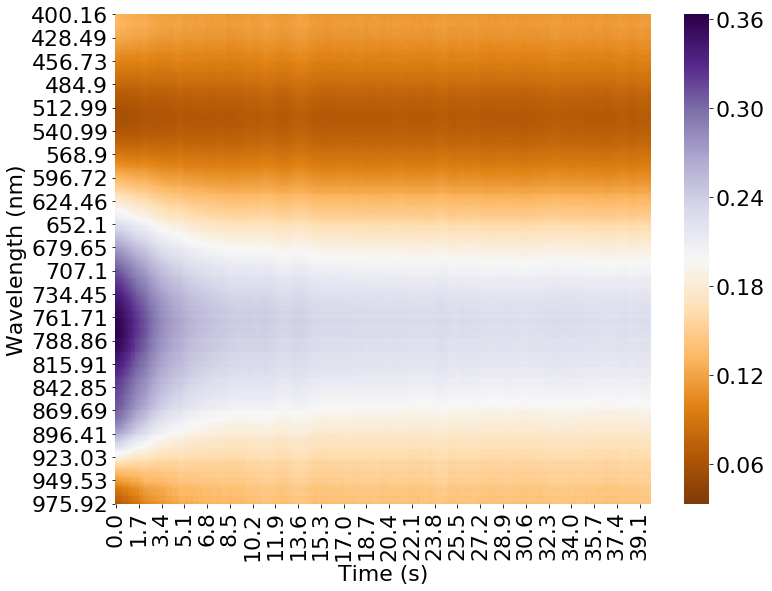

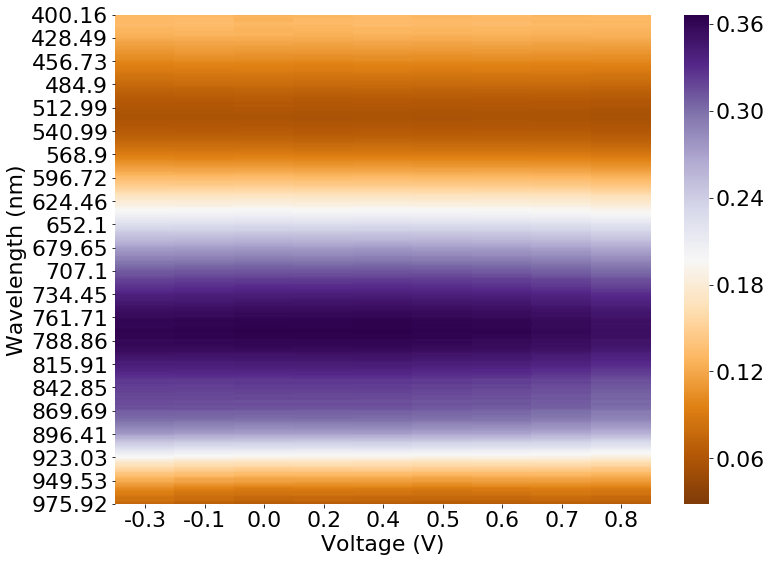

In [29]:
# Change potential to whatever voltage you want
# change cmap only if you know what that means
potential = 0.6
kwargs = {}
kwargs['cmap'] = 'PuOr'

# Sets up two dataframes for plotting
import pandas as pd
import seaborn as sns
wl = np.round(data.spectra_vs_time[potential].index.values, 2)
df = pd.DataFrame.copy(data.spectra_vs_time[potential])
df = df.set_index(wl)
dfv = pd.DataFrame.copy(data.spectra_sm)
dfv = dfv.set_index(wl)

# spectra vs time
fig, ax0 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
sns.heatmap(df,ax=ax0, **kwargs)    
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Wavelength (nm)')

plot_name = 'Spectrogram at ' + str(potential) + ' V '+filenamestring+'.png'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg')
plt.savefig(path + r'//' + 'Spectrogram at ' + str(potential) + ' V '+filenamestring+'.png')

# spectra vs voltage
fig, ax1 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
sns.heatmap(dfv,ax=ax1, **kwargs)    
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Wavelength (nm)')

plot_name =  'Spectrogram at t = 0 s' +filenamestring+'.png'
working_path = data_folder / plot_name
#plt.savefig(path + r'//' + 'Spectrogram at t = 0 s' +filenamestring+'.jpg')
plt.savefig(working_path)

In [ ]:
if dedata:
        # Change potential to whatever voltage you want
    # change cmap only if you know what that means
    #potential = 0.7
    kwargs = {}
    kwargs['cmap'] = 'icefire'

    # Sets up two dataframes for plotting
    import pandas as pd
    import seaborn as sns
    wl = np.round(dedata.spectra_vs_time[potential].index.values, 2)
    df = pd.DataFrame.copy(dedata.spectra_vs_time[potential])
    df = df.set_index(wl)
    dfv = pd.DataFrame.copy(dedata.spectra_sm)
    dfv = dfv.set_index(wl)

    # spectra vs time
    fig, ax0 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
    sns.heatmap(df,ax=ax0, **kwargs)    
    ax0.set_xlabel('Time (s)')
    ax0.set_ylabel('Wavelength (nm)')
   
    
    plot_name = 'Dedoping Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg'
    working_path = data_folder / plot_name
#    plt.savefig(path + r'//' + 'Dedoping Spectrogram at ' + str(potential) + ' V '+filenamestring+'.jpg')
    plt.savefig(working_path)


    # spectra vs voltage
    fig, ax1 = plt.subplots(nrows = 1, figsize=(12,9), facecolor='white')
    sns.heatmap(dfv,ax=ax1, **kwargs)    
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Wavelength (nm)')

    plot_name = 'Dedoping Spectrogram at t = 0 s' +filenamestring+'.jpg'
    working_path = data_folder / plot_name
#    plt.savefig(path + r'//' + 'Dedoping Spectrogram at t = 0 s' +filenamestring+'.jpg')
    plt.savefig(working_path)
    

## 3. A brief tour through what this all contains for your reference

## (This part is not necessary to run)

In [ ]:
# data.spectra -- the data as one large dataframe vs voltage
data.spectra

In [ ]:
# All the spectra vs time
data.spectra_vs_time

In [ ]:
data.time_spectra_norm # normalized time-dependent spectra

In [ ]:
data.time_spectra # un-normalized time-dependent spectra

### This cell saves to a csv file the time dependance at all wavelengths and one voltage.

In [210]:
for p in data.spectra_vs_time:
    
    data.spectra_vs_time[p].T.to_csv(data_path / Path('time_dependent_spectra' + str(p) + '.csv'))


### Saves a wavelength and voltage spectra to CSV

In [35]:
wavelength = 550
potential = 0.7

data.single_wl_time(wavelength=wavelength, potential=potential)

data_name = 'abs_vs_time_'+str(potential)+ ' at '+str(wavelength) + ' nm'+'.csv'
working_path = data_folder / data_name
data.time_spectra_sm.T.to_csv(working_path)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

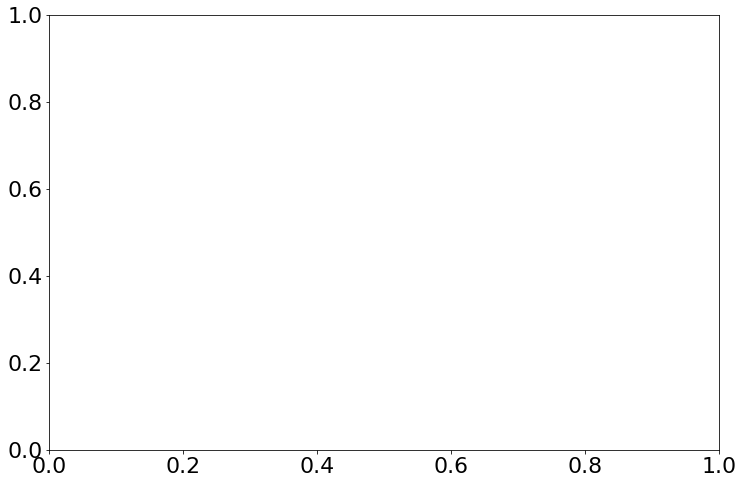

In [180]:
# Biexponential kinetics
#Choose wavelengths to plot about
wl_start = 550
wl_stop = 600
potentials = [0.5, 0.6, 0.7, 0.8]
times = {}

# Setup variables for saving data as CSV - DW
potential_volt = []
time_constant_ave = []
std_tc = []
tc_array = []

fig, ax = plt.subplots(nrows=1, figsize=(12,8),  facecolor='white')
colors = ['r', 'k', 'b', 'g', 'xkcd:purple', 'xkcd:dark orange']
for p, c in zip(potentials, colors):
    data.banded_fits(wl_start = wl_start, wl_stop = wl_stop, voltage=p, fittype='biexp')
    times[p] = data.fits
    ax.plot(p * np.ones(len(data.fits)), times[p][:,0], 'o', **{'color': c, 'markersize':6})
    ax.plot(p * np.ones(len(data.fits)), times[p][:,1], 'x', **{'color': c, 'markersize':12})

    filename_var = "all_tcs_"+str(p)+".csv"
    save_name_path =  data_folder  / filename_var
    np.savetxt(save_name_path, times[p], delimiter=",")
    
    potential_volt.append(p)
    time_constant_ave.append(np.mean(times[p][0]))
    std_tc.append(np.std(times[p][0]))    

# Saves time constant as CSV containing potential, time constant, standard deviation
filename_var = "tc_mean_range.csv"
save_name_path =  data_folder  / filename_var
tc_array = np.vstack((potential_volt, time_constant_ave, std_tc)).T
np.savetxt(save_name_path, tc_array, delimiter=",")    
    
ax.set_ylabel('Time Constant (s)')
ax.set_xlabel('Potential (V)')
ax.set_title('Biexp Doping Potential-Dependent Rates from ' + str(wl_start) + ' nm to ' + str(wl_stop ) + ' nm')

plot_name = 'Biexp Doping Potential-Dependent Kinetics from '+str(wl_start)+' nm to '+str(wl_stop )+' nm'+filenamestring+'.jpg'
working_path = data_folder / plot_name
plt.savefig(working_path)

### Dean's Scratchpad

In [ ]:
data.spectra_vs_time[0.2].T.to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data2_R4b.csv') 

In [ ]:
data.fits

In [ ]:
data.spectra_vs_time[0.2].T

In [ ]:
data.spectra_vs_time[0.7].T[800.14].to_csv('/Users/waldow/Downloads/20191206 Data/R4 65% P3HT/data7_R4_800.csv')

In [ ]:
data.banded_fits

In [ ]:
data.fits

In [ ]:
np.argmax(data.spectra_vs_time[0.2].T.loc[0.0]) # Find wavelength of max abs of potential '0.2'

In [ ]:
data.spectra_vs_time[0.2].T.loc[0.2] # all wavelengths at a certain time.

In [ ]:
# Find wavelength of max abs of potential '0.2'
print (np.argmax(data.spectra_vs_time[0.2].T.loc[0.0]))
# Find max abs of potential '0.2'
print (np.max(data.spectra_vs_time[0.2].T.loc[0.0]))
#
print (np.std(data.spectra_vs_time[0.2].T.loc[0.0]))